# Deep learning with tensorflow

## Convolutional network

## Create data
The data are generated by a python script in Blender :
- 900 point of views for each 54 cards.
- Each generated images as a resolution of 128 * 128.
- A total of 48 600 images.

## Create Data with blender

This step require [Blender](https://www.blender.org/download/) in order to generate the images
* Open TextureCards/cardgames.blend
* Run script (See screenshot below)

![Run blender script](https://raw.githubusercontent.com/Claudiooo/DeepLearningLearning/Group2/Images/blender_run.png)

### Blender script

```python
from os import listdir
from os import makedirs
from os.path import isfile, join, splitext, exists
from os.path import basename
import bpy

path = bpy.path.abspath("//")
onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and splitext(f)[1] == '.png']
for f in onlyfiles:
    img = img = bpy.data.images.load(path + f)
    tex = bpy.data.textures.new(f, 'IMAGE')
    tex.image = img
    
    bpy.data.materials['texture_card'].active_texture = tex
    dir = path + '..\\Data\\' + splitext(f)[0]
    if not exists(dir):
        makedirs(dir)
    bpy.context.scene.render.filepath = dir + "\\"
    bpy.ops.wm.console_toggle()
    print(bpy.context.scene.render.filepath)
    bpy.ops.render.render(animation=True)
```

## Import datasetlib

In [1]:
%run ../importlib.py

import datasetlib

datasetlib.buffer_size = 64000000
create_data = False

importing Jupyter notebook from datasetlib.ipynb


## Define label value

In [2]:
label_tab = {
    '1_club' : 0, '1_diamond' : 1, '1_heart' : 2, '1_spade' : 3,
    '2_club' : 4, '2_diamond' : 5, '2_heart' : 6, '2_spade' : 7,
    '3_club' : 8, '3_diamond' : 9, '3_heart' : 10, '3_spade' : 11,
    '4_club' : 12, '4_diamond' : 13, '4_heart' : 14, '4_spade' : 15,
    '5_club' : 16, '5_diamond' : 17, '5_heart' : 18, '5_spade' : 19,
    '6_club' : 20, '6_diamond' : 21, '6_heart' : 22, '6_spade' : 23,
    '7_club' : 24, '7_diamond' : 25, '7_heart' : 26, '7_spade' : 27,
    '8_club' : 28, '8_diamond' : 29, '8_heart' : 30, '8_spade' : 31,
    '9_club' : 32, '9_diamond' : 33, '9_heart' : 34, '9_spade' : 35,
    '10_club' : 36, '10_diamond' : 37, '10_heart' : 38, '10_spade' : 39,
    'jack_club' : 40, 'jack_diamond' : 41, 'jack_heart' : 42, 'jack_spade' : 43,
    'queen_club' : 44, 'queen_diamond' : 45, 'queen_heart' : 46, 'queen_spade' : 47,
    'king_club' : 48, 'king_diamond' : 49, 'king_heart' : 50, 'king_spade' : 51,
    'joker_red' : 52, 'joker_black' : 53
}

## Define global variables

In [3]:
image_index_filename = 'image_cards.txt'
label_index_filename = 'label_cards.txt'
image_shuffle_index_filename = 'image_shuffle_cards.txt'
label_shuffle_index_filename = 'label_shuffle_cards.txt'
dataset_size = 0
if (create_data == True):
    dataset_size = 48600

## Generate index and label file

In [4]:
if (create_data == True):
    dataset_size = datasetlib.create_index_file(
        "Data/**/*.png",
        label_tab,
        image_index_filename,
        label_index_filename)

In [5]:
if (create_data == True):
    dataset_size = datasetlib.create_shuffle_index_file(
        image_index_filename,
        label_index_filename,
        image_shuffle_index_filename,
        label_shuffle_index_filename)

## Generate binary dataset

In [6]:
if (create_data == True):
    datasetlib.generate_chunck_dataset_thread(
        #souce file
        label_shuffle_index_filename,
        #number data per chunck
        10000,
        #number max of thread
        8,
        #number of chunck, -1 for automatic maximum chunck
        -1,
        #binary type 0 for image, 1 for label
        1)

In [7]:
if (create_data == True):
    datasetlib.generate_dataset(label_shuffle_index_filename, dataset_size, 0, 1)

In [8]:
if (create_data == True):
    datasetlib.generate_chunck_dataset_thread(
        #souce file
        image_shuffle_index_filename,
        #number data per chunck
        10000,
        #number max of thread
        8,
        #number of chunck, -1 for automatic maximum chunck
        -1,
        #binary type 0 for image, 1 for label
        0)

In [9]:
if (create_data == True):
    datasetlib.generate_dataset(image_shuffle_index_filename, dataset_size)

## Configuration of Neural Network

In [10]:
import tensorflow as tf
import time
import numpy as np

print(tf.__version__)

1.4.0


In [11]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Data dimention

In [12]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 128

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size, 3)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 53

## Load data with tensorflow

In [13]:
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes
from datetime import timedelta

dataset_image_file = "image_shuffle_cards.ubyte"
dataset_label_file = "label_shuffle_cards.ubyte"

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

class Datasets(object):
    
    def __init__(self,
               images,
               labels):
        
        self._num_examples = images.shape[0]
        self._images = images.reshape(images.shape[0], images.shape[1] * images.shape[2], images.shape[3])
        self._labels_true = labels
        self._labels = dense_to_one_hot(labels, num_classes)
        self._epochs_completed = 0
        self._index_in_epoch = 0
    
    @property
    def images(self):
        return self._images
    
    @property
    def num_examples(self):
        return self._num_examples

    @property
    def labels(self):
        return self._labels
    
    @property
    def labels_true(self):
        return self._labels_true

    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
          # Finished epoch
            self._epochs_completed += 1
          # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
          # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]

def load_data(source, label, number, offset=0):   
    images = datasetlib.read_image_data(source, num_channels, number, offset)
    labels = datasetlib.read_label_data(label, number, offset)
    train = Datasets(images, labels)
    return base.Datasets(train=train, validation=train, test=train)
    
# generate_ubyte_file(dataset_image_shuffle, 100)
dataset = load_data(dataset_image_file, dataset_label_file, 10000)

print(dataset)

Datasets(train=<__main__.Datasets object at 0x000002D8A3C9E630>, validation=<__main__.Datasets object at 0x000002D8A3C9E630>, test=<__main__.Datasets object at 0x000002D8A3C9E630>)


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

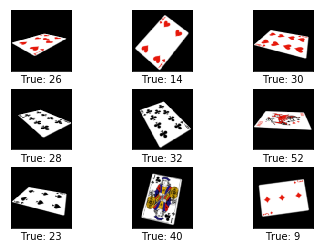

In [15]:
# Get the first images from the test-set.
images = dataset.train.images[0:9]

# Get the true classes for those images.
cls_true = dataset.train.labels_true[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [16]:
#dataset.test.cls = np.argmax(data.test.labels, axis=1)

## TensorFlow graph

In [17]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [18]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [19]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [20]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [21]:

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [22]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat, num_channels], name='x')

In [23]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [24]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [25]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [26]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [27]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 64, 64, 16) dtype=float32>

In [28]:

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [29]:
layer_conv2


<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 36) dtype=float32>

In [30]:
layer_flat, num_features = flatten_layer(layer_conv2)


In [31]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 36864) dtype=float32>

In [32]:
num_features

36864

In [33]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [34]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [35]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [36]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 53) dtype=float32>

In [37]:
y_pred = tf.nn.softmax(layer_fc2)

In [38]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [39]:

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [40]:

cost = tf.reduce_mean(cross_entropy)

In [41]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


In [42]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)


In [43]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [44]:
session = tf.Session()

In [45]:
session.run(tf.global_variables_initializer())

In [46]:
train_batch_size = 64

In [47]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = dataset.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [48]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(dataset.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = dataset.test.images[i:j, :]

        # Get the associated labels.
        labels = dataset.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = dataset.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [49]:
#print_test_accuracy()

optimize(num_iterations=10)

Optimization Iteration:      1, Training Accuracy:   3.1%
Time usage: 0:00:01


In [50]:
optimize(num_iterations=100)

Optimization Iteration:    101, Training Accuracy:   3.1%
Time usage: 0:00:05


In [51]:
optimize(num_iterations=1000)

Optimization Iteration:    201, Training Accuracy:   4.7%
Optimization Iteration:    301, Training Accuracy:  15.6%
Optimization Iteration:    401, Training Accuracy:   0.0%
Optimization Iteration:    501, Training Accuracy:   6.2%
Optimization Iteration:    601, Training Accuracy:   7.8%
Optimization Iteration:    701, Training Accuracy:  10.9%
Optimization Iteration:    801, Training Accuracy:   6.2%
Optimization Iteration:    901, Training Accuracy:  12.5%
Optimization Iteration:   1001, Training Accuracy:  10.9%
Optimization Iteration:   1101, Training Accuracy:   7.8%
Time usage: 0:01:10


In [52]:
optimize(num_iterations=10000)

Optimization Iteration:   1201, Training Accuracy:  17.2%
Optimization Iteration:   1301, Training Accuracy:  12.5%
Optimization Iteration:   1401, Training Accuracy:   6.2%
Optimization Iteration:   1501, Training Accuracy:  15.6%
Optimization Iteration:   1601, Training Accuracy:  18.8%
Optimization Iteration:   1701, Training Accuracy:  23.4%
Optimization Iteration:   1801, Training Accuracy:  26.6%
Optimization Iteration:   1901, Training Accuracy:  25.0%
Optimization Iteration:   2001, Training Accuracy:  18.8%
Optimization Iteration:   2101, Training Accuracy:  25.0%
Optimization Iteration:   2201, Training Accuracy:  32.8%
Optimization Iteration:   2301, Training Accuracy:  31.2%
Optimization Iteration:   2401, Training Accuracy:  32.8%
Optimization Iteration:   2501, Training Accuracy:  40.6%
Optimization Iteration:   2601, Training Accuracy:  32.8%
Optimization Iteration:   2701, Training Accuracy:  50.0%
Optimization Iteration:   2801, Training Accuracy:  32.8%
Optimization I

In [53]:
optimize(num_iterations=1000)

Optimization Iteration:  11201, Training Accuracy:  54.7%
Optimization Iteration:  11301, Training Accuracy:  54.7%
Optimization Iteration:  11401, Training Accuracy:  54.7%
Optimization Iteration:  11501, Training Accuracy:  56.2%
Optimization Iteration:  11601, Training Accuracy:  57.8%
Optimization Iteration:  11701, Training Accuracy:  59.4%
Optimization Iteration:  11801, Training Accuracy:  57.8%
Optimization Iteration:  11901, Training Accuracy:  64.1%
Optimization Iteration:  12001, Training Accuracy:  59.4%
Optimization Iteration:  12101, Training Accuracy:  46.9%
Time usage: 0:00:43


In [54]:
optimize(num_iterations=7899)

Optimization Iteration:  12201, Training Accuracy:  60.9%
Optimization Iteration:  12301, Training Accuracy:  48.4%
Optimization Iteration:  12401, Training Accuracy:  57.8%
Optimization Iteration:  12501, Training Accuracy:  57.8%
Optimization Iteration:  12601, Training Accuracy:  53.1%
Optimization Iteration:  12701, Training Accuracy:  51.6%
Optimization Iteration:  12801, Training Accuracy:  54.7%
Optimization Iteration:  12901, Training Accuracy:  54.7%
Optimization Iteration:  13001, Training Accuracy:  57.8%
Optimization Iteration:  13101, Training Accuracy:  62.5%
Optimization Iteration:  13201, Training Accuracy:  50.0%
Optimization Iteration:  13301, Training Accuracy:  45.3%
Optimization Iteration:  13401, Training Accuracy:  59.4%
Optimization Iteration:  13501, Training Accuracy:  46.9%
Optimization Iteration:  13601, Training Accuracy:  53.1%
Optimization Iteration:  13701, Training Accuracy:  56.2%
Optimization Iteration:  13801, Training Accuracy:  56.2%
Optimization I

In [55]:
optimize(num_iterations=499)

Optimization Iteration:  20101, Training Accuracy:  51.6%
Optimization Iteration:  20201, Training Accuracy:  64.1%
Optimization Iteration:  20301, Training Accuracy:  73.4%
Optimization Iteration:  20401, Training Accuracy:  65.6%
Optimization Iteration:  20501, Training Accuracy:  64.1%
Time usage: 0:00:22


In [56]:
optimize(num_iterations=499)

Optimization Iteration:  20601, Training Accuracy:  62.5%
Optimization Iteration:  20701, Training Accuracy:  59.4%
Optimization Iteration:  20801, Training Accuracy:  54.7%
Optimization Iteration:  20901, Training Accuracy:  60.9%
Optimization Iteration:  21001, Training Accuracy:  67.2%
Time usage: 0:00:23


In [57]:
optimize(num_iterations=6000)

Optimization Iteration:  21101, Training Accuracy:  56.2%
Optimization Iteration:  21201, Training Accuracy:  65.6%
Optimization Iteration:  21301, Training Accuracy:  59.4%
Optimization Iteration:  21401, Training Accuracy:  76.6%
Optimization Iteration:  21501, Training Accuracy:  59.4%
Optimization Iteration:  21601, Training Accuracy:  60.9%
Optimization Iteration:  21701, Training Accuracy:  60.9%
Optimization Iteration:  21801, Training Accuracy:  65.6%
Optimization Iteration:  21901, Training Accuracy:  68.8%
Optimization Iteration:  22001, Training Accuracy:  57.8%
Optimization Iteration:  22101, Training Accuracy:  62.5%
Optimization Iteration:  22201, Training Accuracy:  68.8%
Optimization Iteration:  22301, Training Accuracy:  75.0%
Optimization Iteration:  22401, Training Accuracy:  64.1%
Optimization Iteration:  22501, Training Accuracy:  57.8%
Optimization Iteration:  22601, Training Accuracy:  73.4%
Optimization Iteration:  22701, Training Accuracy:  60.9%
Optimization I

In [58]:
optimize(num_iterations=3000)

Optimization Iteration:  27101, Training Accuracy:  60.9%
Optimization Iteration:  27201, Training Accuracy:  68.8%
Optimization Iteration:  27301, Training Accuracy:  70.3%
Optimization Iteration:  27401, Training Accuracy:  56.2%
Optimization Iteration:  27501, Training Accuracy:  67.2%
Optimization Iteration:  27601, Training Accuracy:  65.6%
Optimization Iteration:  27701, Training Accuracy:  65.6%
Optimization Iteration:  27801, Training Accuracy:  71.9%
Optimization Iteration:  27901, Training Accuracy:  73.4%
Optimization Iteration:  28001, Training Accuracy:  53.1%
Optimization Iteration:  28101, Training Accuracy:  62.5%
Optimization Iteration:  28201, Training Accuracy:  64.1%
Optimization Iteration:  28301, Training Accuracy:  62.5%
Optimization Iteration:  28401, Training Accuracy:  67.2%
Optimization Iteration:  28501, Training Accuracy:  64.1%
Optimization Iteration:  28601, Training Accuracy:  65.6%
Optimization Iteration:  28701, Training Accuracy:  62.5%
Optimization I

This after 30000 iteration the network recognise with 67.2% and the max percentage is 76.6% reach after 16601 iteration